In [15]:
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

In [16]:
# Загрузка модели CLIP
device = "cuda" if torch.cuda.is_available() else "cpu"
# Загрузка архитектуры модели
model, processor = clip.load("ViT-B/32", device=device)

# Загрузка сохраненных весов
model.load_state_dict(torch.load("clip.pt", map_location=device))
model.to(device)
model.eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [17]:
# Загрузка аннотаций COCO
annotations_path = "coco2017/annotations/captions_val2017.json"  # Укажите путь к аннотациям
coco = COCO(annotations_path)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [18]:
# Загрузка изображения
image_path = "coco2017/val2017/000000488385.jpg"
image = processor(Image.open(image_path)).unsqueeze(0).to(device)

In [19]:
# Получение всех аннотаций (текстовых описаний) из COCO
ann_ids = coco.getAnnIds()
annotations = coco.loadAnns(ann_ids)
text_descriptions = [ann['caption'] for ann in annotations]  # Используем все описания
text_descriptions = text_descriptions[:10000]  # Используем первые 1000 описаний

In [20]:
# Токенизация текстовых описаний
text = clip.tokenize(text_descriptions).to(device)

In [21]:
# Получение вероятностей
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

In [22]:
# Вывод результатов
print("Вероятности для каждого описания:")
for desc, prob in zip(text_descriptions, probs[0]):
    print(f"{desc}: {prob:.4f}")

Вероятности для каждого описания:
A black Honda motorcycle parked in front of a garage.: 0.0025
A Honda motorcycle parked in a grass driveway: 0.0009
An office cubicle with four different types of computers.: 0.0000
A small closed toilet in a cramped space.: 0.0000
Two women waiting at a bench next to a street.: 0.0000
A black Honda motorcycle with a dark burgundy seat.: 0.0046
A tan toilet and sink combination in a small room.: 0.0000
The home office space seems to be very cluttered.: 0.0000
A beautiful dessert waiting to be shared by two people: 0.0000
A woman sitting on a bench and a woman standing waiting for the bus.: 0.0000
A woman sitting on a bench in the middle of the city: 0.0000
This is an advanced toilet with a sink and control panel.: 0.0000
A cat eating a bird it has caught.: 0.0000
A close-up picture of a toilet with a fountain.: 0.0000
A shot of an elderly man inside a kitchen.: 0.0000
A cat in between two cars in a parking lot.: 0.0000
A woman sitting on a bench and a 

In [23]:
# Выбор наиболее подходящего описания
best_idx = probs.argmax()
best_description = text_descriptions[best_idx]
best_prob = probs[0][best_idx]
print(f"\n Наиболее подходящее описание: {best_description} (вероятность: {best_prob:.4f})")


 Наиболее подходящее описание: A silver and black sports motorcycle parked near a building. (вероятность: 0.0870)


In [24]:
# Получение истинных аннотаций для изображения
image_id = int(image_path.split("/")[-1].split(".")[0])
ann_ids = coco.getAnnIds(imgIds=image_id)
true_annotations = coco.loadAnns(ann_ids)
true_descriptions = [ann['caption'] for ann in true_annotations]

In [25]:
# Расчет Precision@1
precision_at_1 = 1.0 if best_description in true_descriptions else 0.0

In [26]:
# Вывод метрик
print("Истинные аннотации для изображения:")
for desc in true_descriptions:
    print(f"- {desc}")

Истинные аннотации для изображения:
- The motorcycles are parked on the side of the building.
- A motorcycle parked in front of a building.
- A very nice looking motorcycle with some long handle bars.
- a motorcycle parked beside a window of some building
- A black and white motorcycle parked on the sidewalk outside a store.


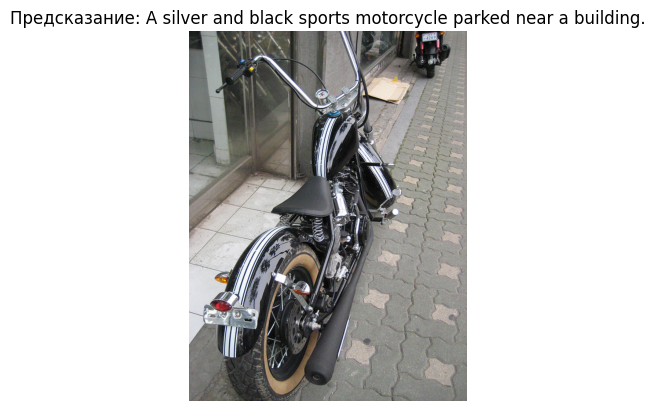

In [27]:
# Визуализация изображения (добавлено для наглядности)
plt.imshow(Image.open(image_path))
plt.axis('off')
plt.title(f"Предсказание: {best_description}")
plt.show()

In [28]:
import numpy as np

top_k_indices = np.argsort(probs[0])[-5:]
top_k_descriptions = [text_descriptions[i] for i in top_k_indices]
top_k_probs = [probs[0][i] for i in top_k_indices]

print("\n Топ-5 описаний:")
for desc, prob in zip(top_k_descriptions, top_k_probs):
    print(f"{desc}: {prob:.4f}")

precision_at_5 = any([desc in true_descriptions for desc in top_k_descriptions])
print(f"\n Precision@5: {precision_at_5 * 100:.2f}%")


 Топ-5 описаний:
A customized motorcycle with a large rear and skinny front tire: 0.0528
A black and white motorcycle parked on the sidewalk outside a store.: 0.0792
a black and silver motor cycle parked by a shed: 0.0817
A motorcycle parked outside of a building with bird cages.: 0.0830
A silver and black sports motorcycle parked near a building.: 0.0870

 Precision@5: 100.00%
